In [1]:
import numpy as np
from DHTVPac.MyPloter import *
from DHTVPac.HTV_Delaunay import MyDelaunay
from DHTVPac.opt_solver import *
import scipy
import pickle
from matplotlib import pyplot as plt

In [2]:
X_train = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_train_points_campos.txt', skiprows=0)
y_train = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_train_values_campos.txt', skiprows=0)

X_test = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_test_points_campos.txt', skiprows=0)
y_test = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_test_values_campos.txt', skiprows=0)

X_valid = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_valid_points_campos.txt', skiprows=0)
y_valid = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_valid_values_campos.txt', skiprows=0)

hex_grid_points = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_grid_points_campos.txt', skiprows=0)

compute_campos = False

if compute_campos:
    H_campos = scipy.sparse.load_npz('HTV-Learn-campos/saved_for_comparison/H_face_campos.npz')
    L_campos = scipy.sparse.load_npz('HTV-Learn-campos/saved_for_comparison/L_face_campos.npz')

    _, s, _ = scipy.sparse.linalg.svds(H_campos, k=1)
    lip_H = s[0] ** 2 

    _, s, _ = scipy.sparse.linalg.svds(L_campos, k=1)
    lip_L = s[0] ** 2 
    
    lmbda = 1e-3

    y_fista_campos, _ = double_fista(y_train, H_campos, L_campos, lip_H, lip_L, lmbda, 500, 400, 
    device='cuda:2', save_dir='noisy_face_results/htv_campos_loss'+str(lmbda)+'.txt')
    fista_solution = y_fista_campos.detach().cpu().numpy()
    np.savetxt('noisy_face_results/htv_campos' + str(lmbda) + '.txt', fista_solution)


In [3]:
load_model = True

if not load_model:
    dhtv_hex = MyDelaunay(X_train, y_train, hex_grid_points)
    dhtv_hex.construct_forward_matrix()
    dhtv_hex.construct_regularization_matrix()
    file_to_store = open("noisy_face_results/dhtv_hex.pickle", "wb")
    pickle.dump(dhtv_hex, file_to_store)
    file_to_store.close()
else:
    file_to_read = open("noisy_face_results/dhtv_hex.pickle", "rb")
    dhtv_hex = pickle.load(file_to_read)
    file_to_read.close()

lmbda = 1e-3

load_vals = True

if not load_vals:
    y_fista_dhtv, _ = double_fista(dhtv_hex.data_values, dhtv_hex.H, dhtv_hex.L, dhtv_hex.lip_H, dhtv_hex.lip_L, lmbda, 500, 400, 
    device='cuda:2', save_dir='noisy_face_results/dhtv_hex_loss'+str(lmbda)+'.txt')
    fista_solution = y_fista_dhtv.detach().cpu().numpy()
    np.savetxt('noisy_face_results/dhtv_hex_fista_sol_' + str(lmbda) + '.txt', fista_solution)
else:
    fista_solution = np.loadtxt('noisy_face_results/dhtv_hex_fista_sol_' + str(lmbda) + '.txt')

train_mse = np.mean((y_train - dhtv_hex.evaluate(X_train, fista_solution))**2)
test_mse = np.mean((y_test - dhtv_hex.evaluate(X_test, fista_solution))**2)
valid_mse = np.mean((y_valid - dhtv_hex.evaluate(X_valid, fista_solution))**2)
htv = np.sum(np.abs(dhtv_hex.L.dot(fista_solution)))

print('train mse:',  float('{:.3E}'.format(train_mse)))
print('valid mse:', float('{:.3E}'.format(valid_mse)))
print('test mse:' , float('{:.3E}'.format(test_mse)))
print('HTV', float('{:.3E}'.format(htv)))

'''dhtv_hex.update_values(fista_solution)
plot_with_gradient_map(dhtv_hex, 1, 1, 1, 1)'''

train mse: 5.516e-06
valid mse: 2.633e-06
test mse: 2.372e-06
HTV 23.69


'dhtv_hex.update_values(fista_solution)\nplot_with_gradient_map(dhtv_hex, 1, 1, 1, 1)'

In [4]:
load_model = True

if not load_model:
    dhtv_I = MyDelaunay(X_train, y_train)
    dhtv_I.construct_forward_matrix()
    dhtv_I.construct_regularization_matrix()
    file_to_store = open("noisy_face_results/dhtv_I.pickle", "wb")
    pickle.dump(dhtv_I, file_to_store)
    file_to_store.close()
else:
    file_to_read = open("noisy_face_results/dhtv_I.pickle", "rb")
    dhtv_I = pickle.load(file_to_read)
    file_to_read.close()

lmbda = 8e-4

load_vals = True

if not load_vals:
    y_fista_dhtv, _ = double_fista(dhtv_I.data_values, dhtv_I.H, dhtv_I.L, dhtv_I.lip_H, dhtv_I.lip_L, lmbda, 1, 200000, 
    device='cuda:3', save_dir='noisy_face_results/dhtv_I_loss'+str(lmbda)+'.txt')
    fista_solution = y_fista_dhtv.detach().cpu().numpy()
    np.savetxt('noisy_face_results/dhtv_I_fista_sol_' + str(lmbda) + '.txt', fista_solution)
else:
    fista_solution = np.loadtxt('noisy_face_results/dhtv_I_fista_sol_' + str(lmbda) + '.txt')

train_mse = np.mean((y_train - dhtv_I.evaluate(X_train, fista_solution))**2)
test_mse = np.mean((y_test - dhtv_I.evaluate(X_test, fista_solution))**2)
valid_mse = np.mean((y_valid - dhtv_I.evaluate(X_valid, fista_solution))**2)
htv = np.sum(np.abs(dhtv_I.L.dot(fista_solution)))


print('train mse:',  float('{:.3E}'.format(train_mse)))
print('valid mse:', float('{:.3E}'.format(valid_mse)))
print('test mse:' , float('{:.3E}'.format(test_mse)))
print('HTV', float('{:.3E}'.format(htv)))

'''dhtv_I.update_values(fista_solution)
plot_with_gradient_map(dhtv_I, 1, 1, 0, 1)'''

train mse: 4.178e-06
valid mse: 2.512e-06
test mse: 2.434e-06
HTV 27.31


'dhtv_I.update_values(fista_solution)\nplot_with_gradient_map(dhtv_I, 1, 1, 0, 1)'

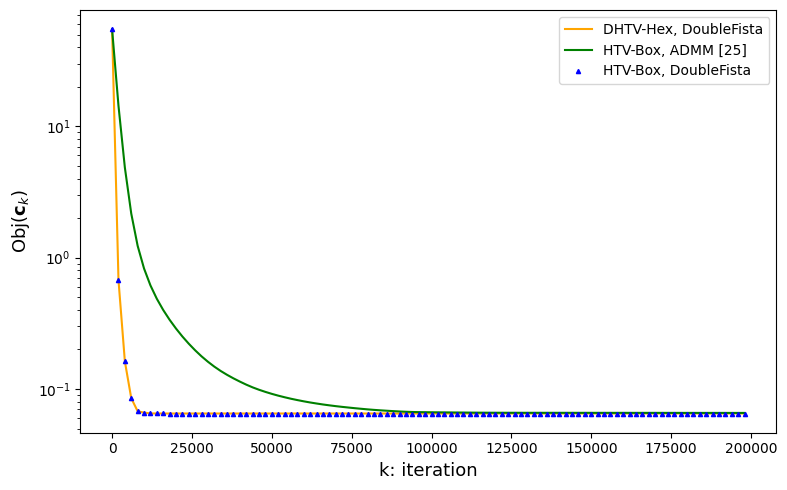

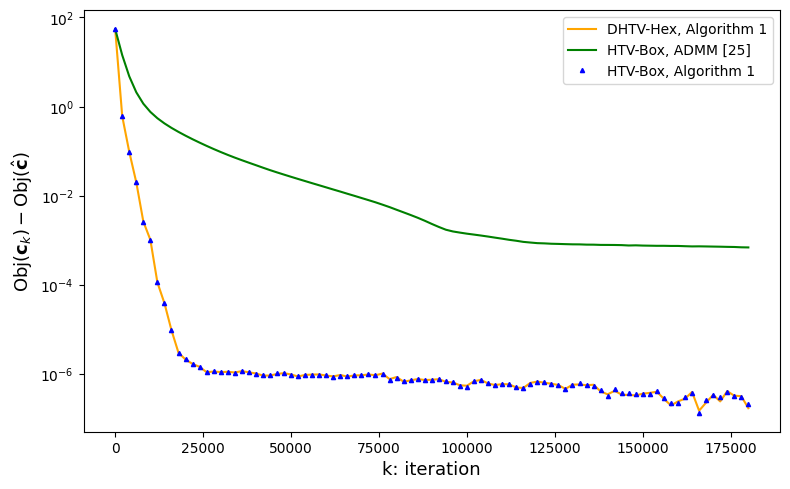

In [12]:
# compare loss 

dhtv_hex_loss = np.loadtxt('noisy_face_results/dhtv_hex_loss0.001.txt')
campos_loss_doublefista = np.loadtxt('noisy_face_results/htv_campos_loss0.001.txt')
campos_loss_admm = np.loadtxt('HTV-Learn-campos/saved_for_comparison/face_loss0.001.txt')

iters = np.arange(0, 100) * 2000

i = 2 # for total loss, 0: data fideltiy 1:htv

plt.figure(figsize=(8, 5))
plt.plot(iters, dhtv_hex_loss[:, i], 'orange', label='DHTV-Hex, DoubleFista')
plt.plot(iters, campos_loss_admm[:, i], 'green', label='HTV-Box, ADMM [25]')
plt.plot(iters, campos_loss_doublefista[:, i], '^', label='HTV-Box, DoubleFista', markersize=3, color='blue')
plt.yscale('log')
plt.legend()
plt.ylabel('$\mathrm{Obj}(\mathbf{c}_{k})$', fontsize=13)
plt.xlabel('k: iteration', fontsize=13)
plt.tight_layout()
plt.show()

iters = np.arange(0, 91) * 2000

plt.figure(figsize=(8, 5))
plt.plot(iters, dhtv_hex_loss[:91, i] - dhtv_hex_loss[99, i], 'orange', label='DHTV-Hex, Algorithm 1')
plt.plot(iters, campos_loss_admm[:91, i] - dhtv_hex_loss[99, i], 'green', label='HTV-Box, ADMM [25]')
plt.plot(iters, campos_loss_doublefista[:91, i] - dhtv_hex_loss[99, i], '^', label='HTV-Box, Algorithm 1', markersize=3, color='blue')
plt.yscale('log')
plt.legend()
plt.ylabel('$\mathrm{Obj}(\mathbf{c}_{k}) - \mathrm{Obj}(\hat{\mathbf{c}})$', fontsize=13)
plt.xlabel('k: iteration', fontsize=13)
plt.tight_layout()
plt.savefig('noisy_face_results/face_opt_compare.pdf')
plt.show()